In [1]:
#Step 1: Set up the environment

# import spacec first
import spacec as sp
# import standard packages
import os
import re
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc.settings.set_figure_params(dpi=80, facecolor='white') 
# set the default color map to viridis, the below paramters can be chanaged
matplotlib.rcParams["image.cmap"] = 'viridis'

# Specify the path to the data
root_path = "/homes/zhanyx3/PTPN2_phenocycler/" # replace with your path
data_path = root_path + 'Images/' # where the data is stored

# where you want to store the output
output_dir = root_path + 'Yao/output/'
os.makedirs(output_dir, exist_ok=True)


/homes/zhanyx3/miniconda3/envs/spacec/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-10-21 13:52:20.089166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.3.1/lib/R/lib:/.singularity.d/libs:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2025-10-21 13:52:20.089186: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



--- Tile Processing Progress ---
Image Size: 33600x51120 | Grid: 9x13 | Total Tiles: 117
Completed: 117/117 (100.0%)
┌─────────────────┐
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
│✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓│
└─────────────────┘
Legend: P = Processing, ✓ = Completed, □ = Pending


Stitching masks...
Stitching 117 masks with overlap=128, sigma=64...
  Preparing tiles (label offset and confidence)...
  Skipped 41 empty or invalid tiles.
  Processed 76 tiles in first pass. Max label offset: 363160
  Merging tiles...
  Relabeling final mask...
  Relabeling complete. Final max label: 337350
Stitching finished in 467.29 seconds.
Resizing final mask to original image shape...

--- Extracting Features ---
Quantifying features for segmented objects...
--- Starting Feature Extraction ---
Calculating morphologi

Processing channels: 100%|██████████| 57/57 [19:23<00:00, 20.42s/it]


Combining morphology and intensity features...
Successfully saved features for 337350 objects to /homes/zhanyx3/PTPN2_phenocycler/Yao/output/M20-124_30012-2_NSCLC_features.csv
--- Feature Extraction Complete ---
Saved features to /homes/zhanyx3/PTPN2_phenocycler/Yao/output/M20-124_30012-2_NSCLC_features.csv

--- Segmentation Pipeline Complete ---
Combining channels ['E-cadherin'] into 'segmentation_channel' using max projection.


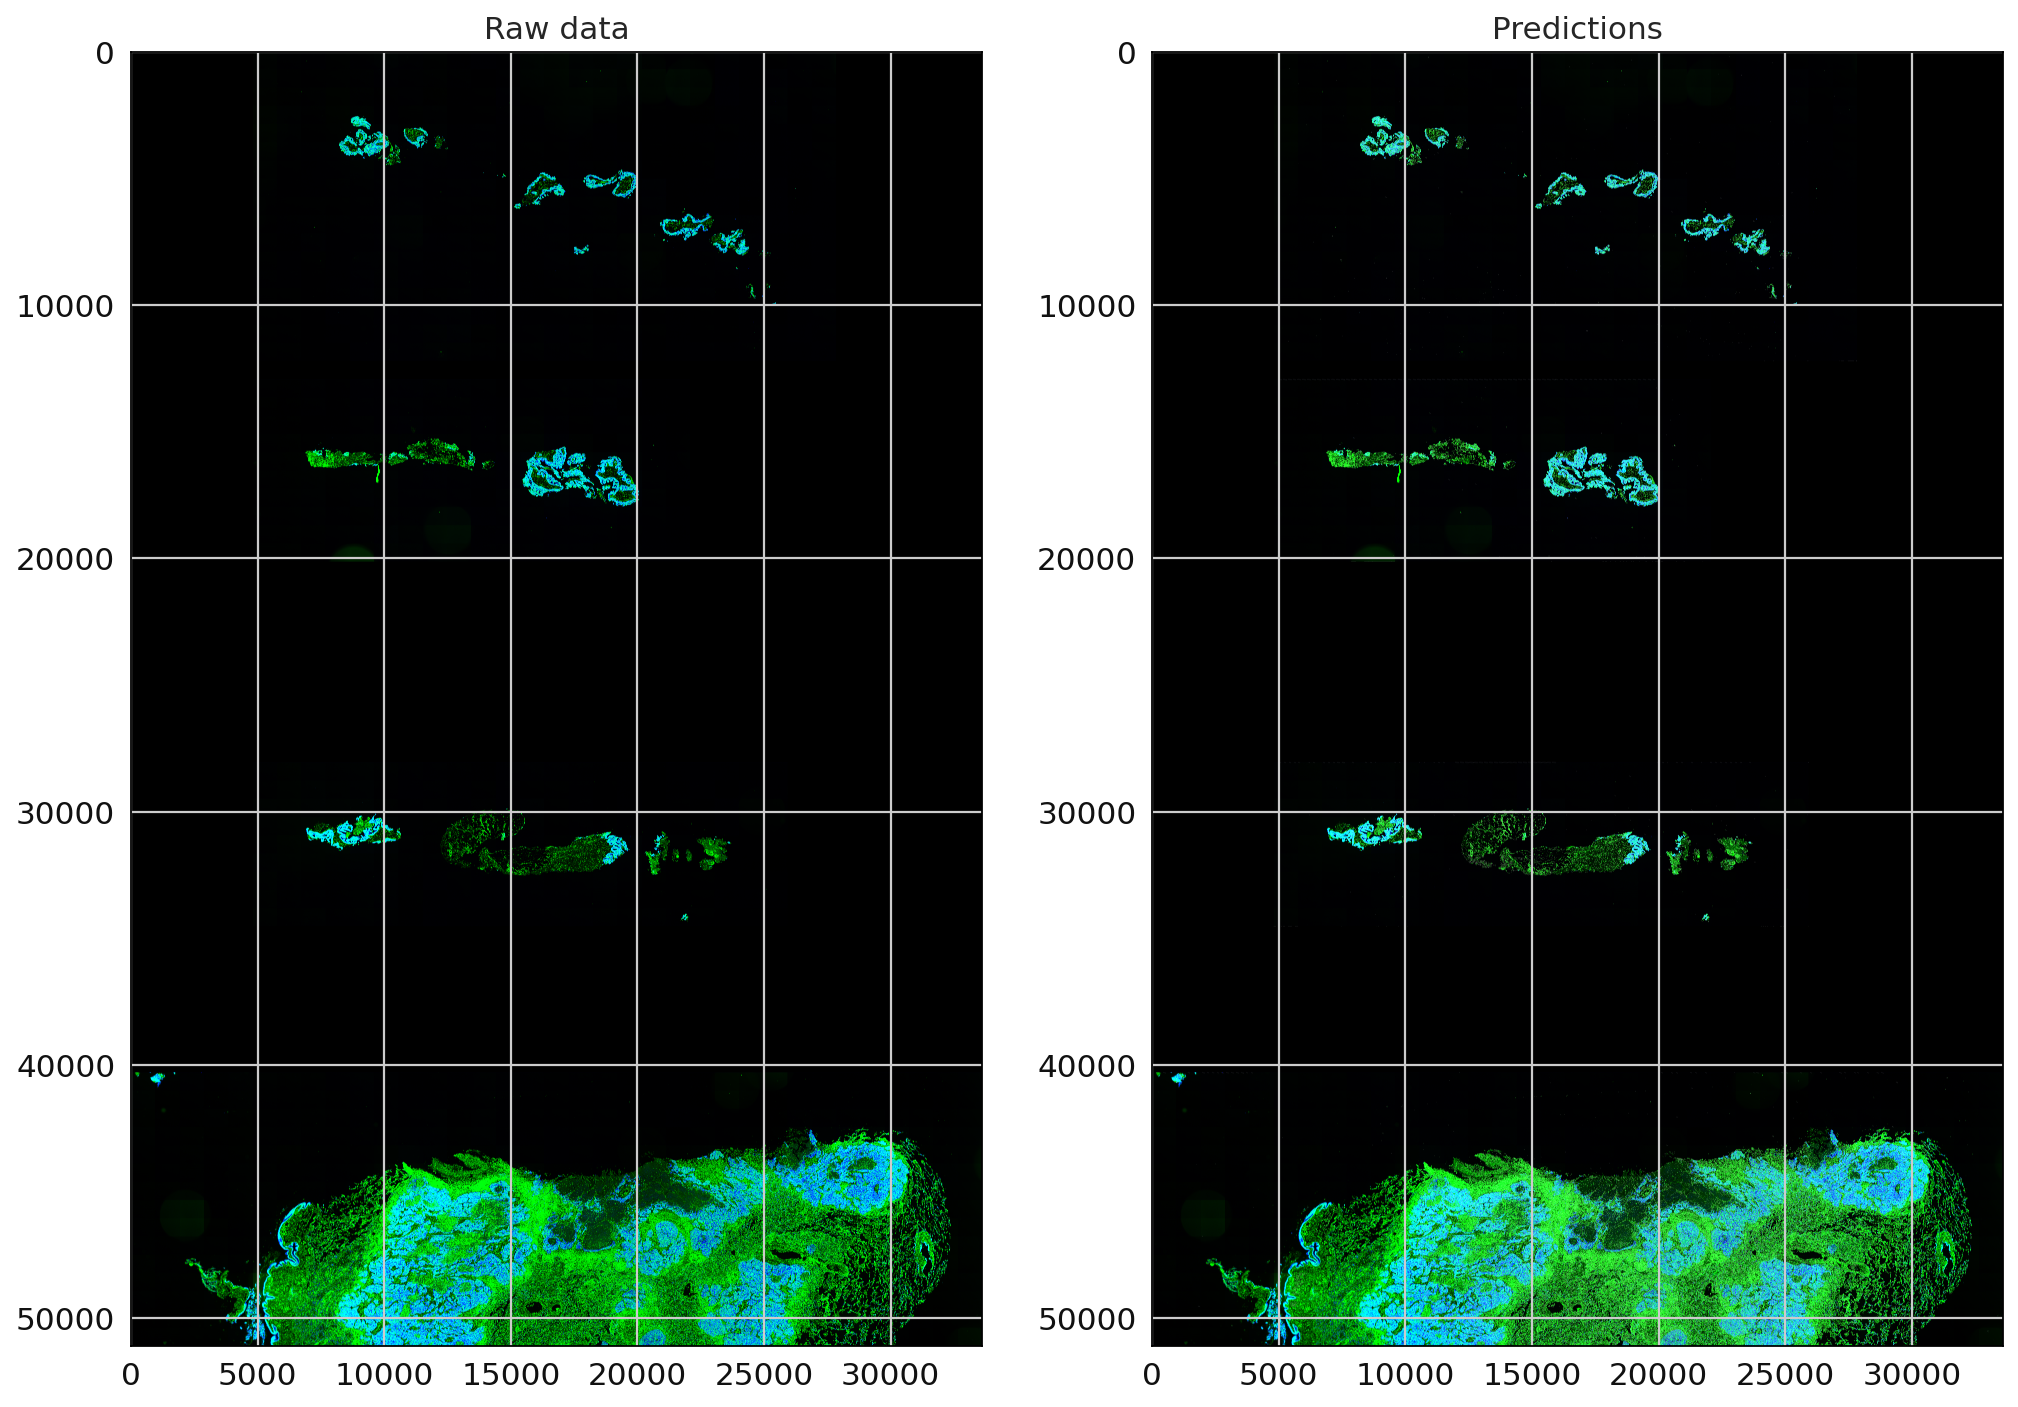

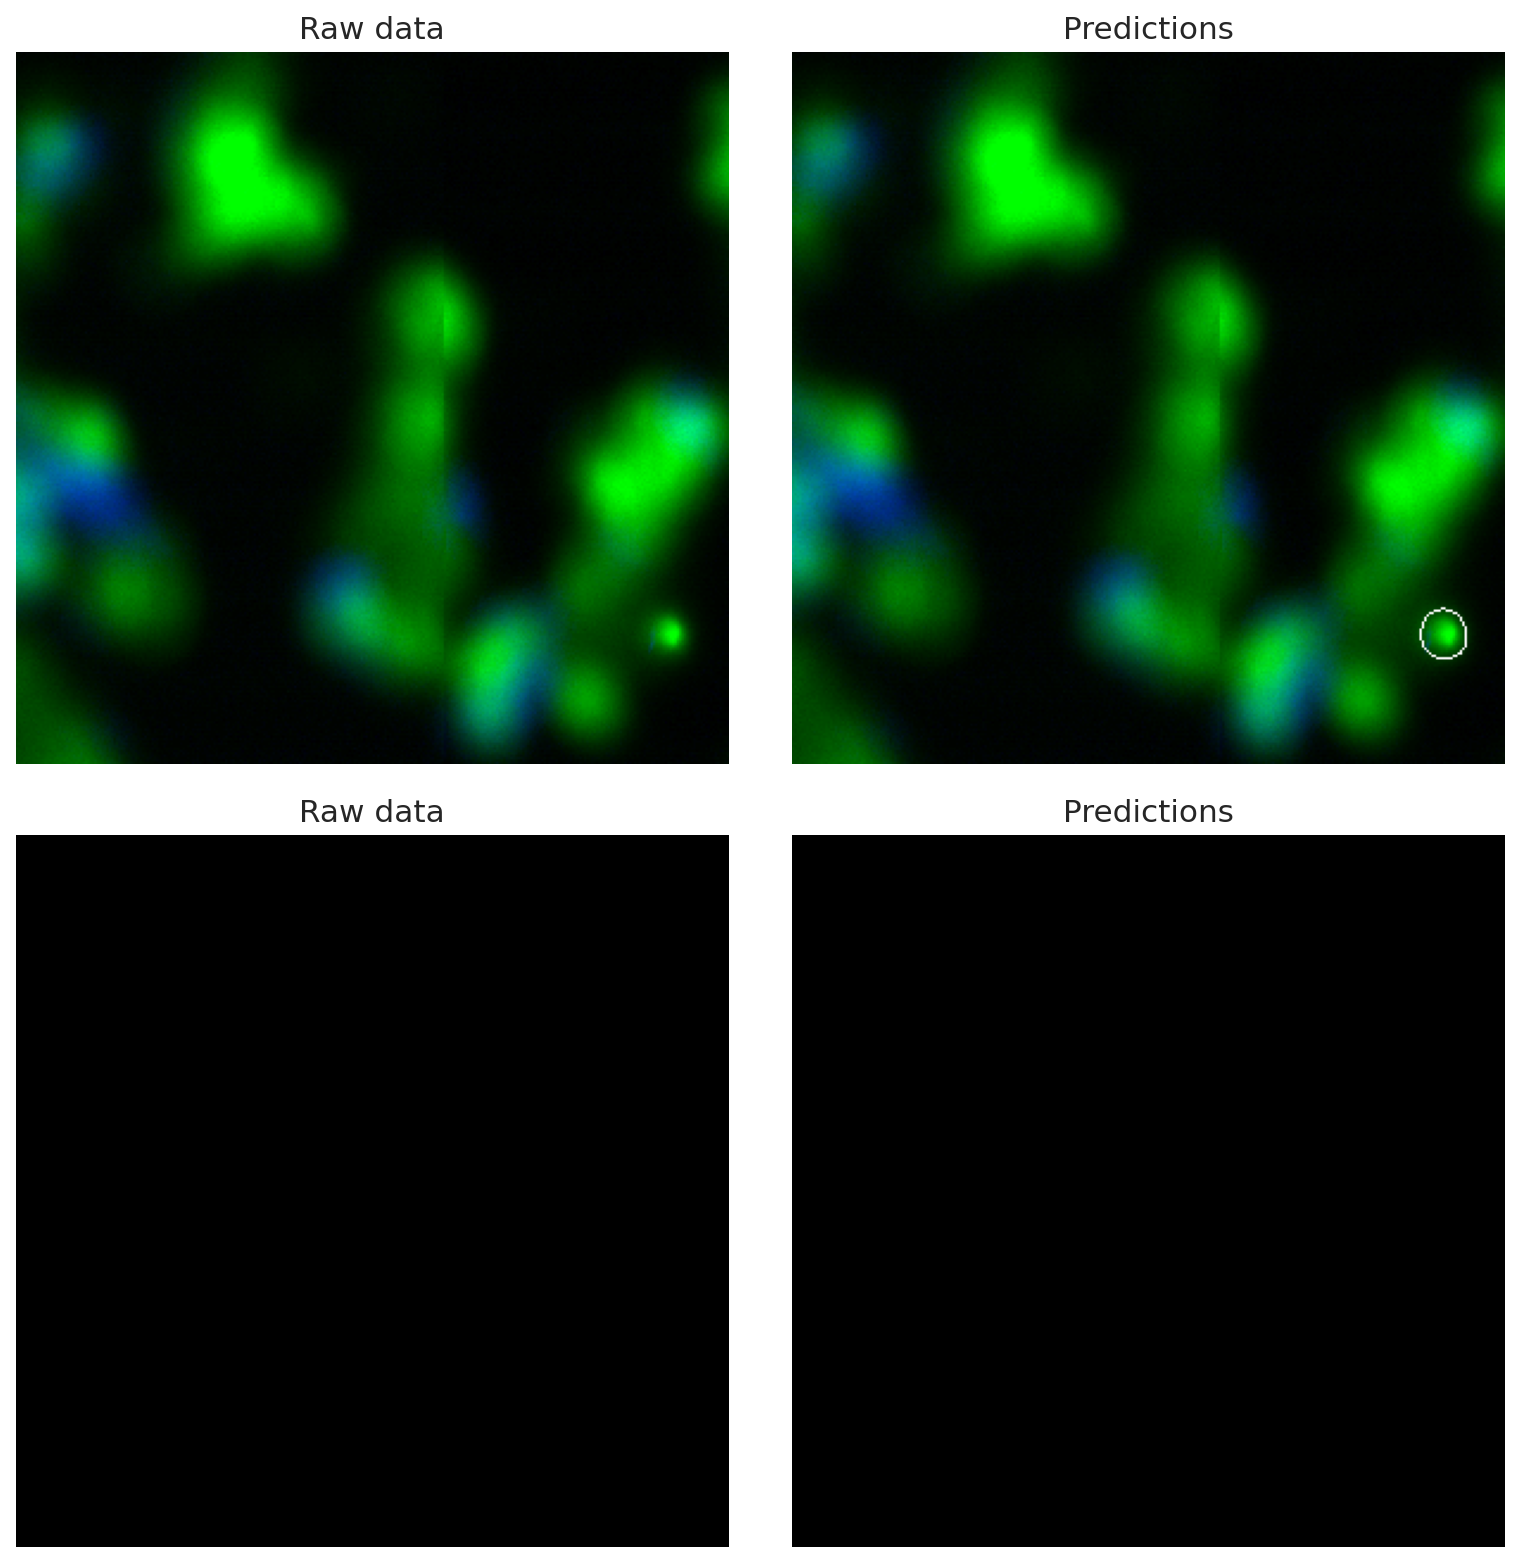

In [6]:
#1. list all tiff raw files 
adatalist = os.listdir(data_path)
adatalist


for file in adatalist:
    file_path = data_path + file # the path to the image
    
    #A step 1: cancer type
    
    cancer_types = re.search(r'(NSCLC|HNSCC)', file).group(1)
    
    samplename = file.replace(' ', '_').split('_SCR')[0]
    
    print(cancer_types,samplename)
    
    
    #A Step 2: Downscale the tissue image downscale your image for easy segmentation computation
    resized_im = sp.hf.downscale_tissue(file_path = file_path, # where qptiff or tiff is stored
                                    downscale_factor = 64, # the downscale factor for the image
                                    padding = 50, # the padding to add to the image
                                    output_dir = output_dir # where to store the downscale image
                                    )
    
    
    #A Step 3: Visualize tissue region number Segment individual tissue pieces

    tissueframe = sp.tl.label_tissue(resized_im, # the downsampled image
                                 lower_cutoff = 0.2, #the lower cutoff of the image intensity for the tissue
                                 upper_cutoff = 0.21 #the upper cutoff of the image intensity for the tissue
                                 )

    #A Step4 read in compiled measurement csv, to extract channelnames.txt
    measurement = '/homes/zhanyx3/PTPN2_phenocycler/Cell_Data/' + cancer_types + '_measurements.csv' # where the data is stored
    df = pd.read_csv(measurement)
    # df.columns
    # ## write the metadata to csv
    # pd.Series(df.columns).to_csv('/homes/zhanyx3/PTPN2_phenocycler/Yao/output/column_names_NSCLC.csv', 
    #                              index=False, header=False)

    channelnames = [re.match(r'^Nucleus: (.*): Median$', col).group(1)
                  for col in df.columns if re.match(r'^Nucleus: .*: Median$', col)]

    #The `(.*)` captures whatever text appears between 'Nucleus: ' and ': Median'.
    #`group(1)` gives you exactly the text matched by `(.*)`.

    # Save to CSV
    # to_save = pd.Series(channelnames)
    # to_save.to_csv('/homes/zhanyx3/PTPN2_phenocycler/Yao/output/channelnames.csv', index=False, header=False)

    #To save your results (such as a list of column names) to a text file in Python, use this pattern:
    channelfile = '/homes/zhanyx3/PTPN2_phenocycler/Yao/output/' + 'channelnames_' + samplename + '_' + cancer_types + '.txt'
    
    with open(channelfile, 'w') as f:
        for item in channelnames:
            f.write(str(item) + '\n')
    
    # B  Cell segmentation and visualization.
    #Step 5: Visualize segmentation channel
    
    sp.pl.segmentation_ch(
        file_name = file_path, # image for segmentation
        channel_file = channelfile, # all channels used for staining
        output_dir = output_dir, #
        extra_seg_ch_list = ['E-cadherin','Pan_Cytokeratin'], #default is None; if provide more than one channel, then they will be combined
        nuclei_channel = 'DAPI', # channel to use for nuclei segmentation
        input_format = 'Multichannel', 
    )
    
    
    #B. Step 6: Cell segmentation
    # choose between cellpose or mesmer for segmentation
    # seg_output contains {'img': img, 'image_dict': image_dict, 'masks': masks}

    seg_output = sp.tl.cell_segmentation(
        file_name = file_path,
        channel_file = channelfile,
        output_dir = output_dir,
        seg_method ='mesmer', # cellpose or mesmer
        nuclei_channel = 'DAPI',
        output_fname = samplename + '_' + cancer_types,
        membrane_channel_list = ['E-cadherin','Pan_Cytokeratin'], #default is None; if provide more than one channel, then they will be combined
        compartment = 'whole-cell', # mesmer # segment whole cells or nuclei only
        input_format ='Multichannel', # Phenocycler or codex
        resize_factor=1, # default is 1; if the image is too large, lower the value. Lower values will speed up the segmentation but may reduce the accuracy.
        size_cutoff = 0)
    
    #B.3. Step 7: Visually inspect segmentation results
    overlay_data, rgb_images = sp.pl.show_masks(
        seg_output=seg_output,
        nucleus_channel = 'DAPI', # channel used for nuclei segmentation (displayed in blue)
        additional_channels = ['E-cadherin','Pan_Cytokeratin'], # additional channels to display (displayed in green - channels will be combined into one image)
        show_subsample = True, # show a random subsample of the image
        n=2, #need to be at least 2
        tilesize = 300,# number of subsamples and tilesize
        rand_seed = 3)

    #Save segmentation output
    with open(output_dir + 'seg_output_' + samplename + '.pickle', 'wb') as f:
        pickle.dump(seg_output, f)

    #Save the overlay of the data
    with open(output_dir + 'overlay_' + samplename + '.pickle', 'wb') as f:
        pickle.dump(overlay_data, f)

    